In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from tqdm import tqdm
from pyod.models.copod import COPOD

#### Util functions

In [2]:
def read_word_list(file_name:str):
    result = []
    with open(file_name) as fp:
        result.extend([word.strip() for word in fp.readlines()])
    return result

#### Letter frequencies

In [3]:
# Create a list of each letter in the alphabet
ALPHABET = list(string.ascii_lowercase)

In [4]:
# Read in word lists
accepted_words_list = read_word_list("data/palavras_possiveis.txt")

In [5]:
# Create a dictionary that counts the number of ooccurrences of
# each letter
words_string = ''.join(accepted_words_list)
letter_counts = dict(Counter(words_string))

# Create DataFrame containing the frequency of each letter in all words
letter_frequencies = {k:v/len(accepted_words_list) for k,v in letter_counts.items()}
letter_frequencies = pd.DataFrame({'Letter':list(letter_frequencies.keys()),
                                   'Frequency':list(letter_frequencies.values())}).sort_values('Frequency',
                                                                                               ascending=False)

Text(0.5, 1.0, 'Frequency of Letters in 5-Letter Words')

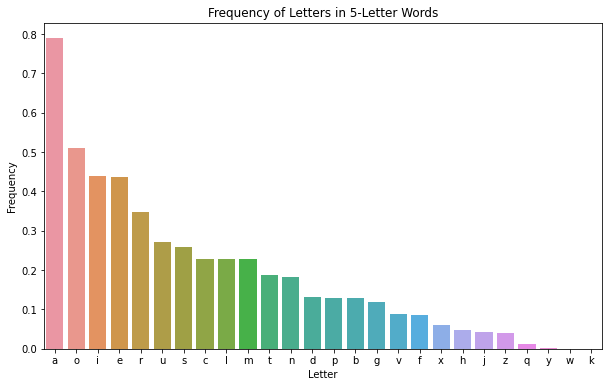

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x='Letter', y='Frequency', data=letter_frequencies)
ax.set_title('Frequency of Letters in 5-Letter Words')

#### One-hot  encoded word data

In [7]:
letter_freq_cols = []
for letter in ALPHABET:
    for position in range(5):
        letter_freq_cols.append(f'{letter}{position}')

In [8]:
# Create letter/position occurrence matrix
letter_pos_freq = pd.DataFrame()

# For each word in the list of accepted words
for word in tqdm(accepted_words_list):
    
    # Convert the word to it letter-position format
    word_and_pos = ''.join([f"{letter}{pos}" for pos, letter in enumerate(word)])
    
    # Create letter-position counter dictionary
    letter_pos_counter = {}
    for wp in letter_freq_cols:
        letter_pos_counter[wp] = len(re.findall(wp, word_and_pos))

    tmp_pos_freq = pd.DataFrame(letter_pos_counter, index=[word])
    letter_pos_freq = pd.concat([letter_pos_freq, tmp_pos_freq])
    
letter_pos_freq.head()

100%|██████████████████████████| 12586/12586 [01:05<00:00, 191.87it/s]


,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4,...,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
ababa,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
ababe,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
abaci,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaca,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abace,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
letter_pos_freq_possible = letter_pos_freq[letter_pos_freq.index.isin(accepted_words_list)]

# Drop columns with all zeros
for col in letter_pos_freq_possible.columns:
    
    if letter_pos_freq_possible[col].sum() == 0:
        letter_pos_freq_possible.drop(col, axis=1, inplace=True)
        letter_pos_freq.drop(col, axis=1, inplace=True)
        
letter_pos_freq_possible.head()

,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4,...,x3,x4,y1,y2,y4,z0,z1,z2,z3,z4
ababa,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
ababe,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
abaci,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaca,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abace,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Fit COPOD model
copod_model = COPOD(contamination=0.01)
copod_model.fit(letter_pos_freq_possible)

COPOD(contamination=0.01, n_jobs=1)

In [11]:
letter_pos_freq_possible['score'] = copod_model.decision_scores_
letter_pos_freq_possible.sort_values('score',inplace=True)

letter_pos_freq_possible['rank'] = range(1,len(letter_pos_freq_possible)+1)
letter_pos_freq_possible.head(5)[['score','rank']]

,score,rank
carao,11.694889,1
marao,11.913747,2
parao,11.997976,3
maiao,12.004646,4
corao,12.008475,5


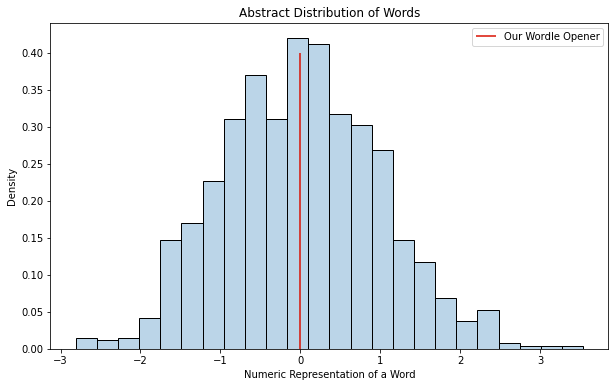

In [12]:
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(np.random.normal(size=1000), stat='density',alpha=0.3)
ax.vlines(x=0, ymin=0, ymax=0.4, color='#d90e00', label='Our Wordle Opener')
ax.set_xlabel('Numeric Representation of a Word')
ax.set_title('Abstract Distribution of Words')
ax.legend()